In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define a matrix, mask and noise
p = 0.75
rank = 1

n = 4

U = np.random.randn(n, rank)
V = np.random.randn(n, rank)
original = np.dot(U, V.T)
mask = np.random.choice([0, 1], size=(n,n), p=[1-p, p])

In [4]:
starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

current_point = starting_point

In [5]:
def obj_func(m, index):
    u, s, vh = np.linalg.svd(m)

    return s[index]

def comp_grad(m, boolMask, obj_func, index, n):
    """ Computes gradient that maximizes the objective function """
    epsilon = 1e-3

    # Yes, grad is a vector now
    grad = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad.append((obj_func(m + diff, index) - obj_func(m - diff, index))/(2*epsilon))

    return grad

In [6]:
def comp_hessian(m, boolMask, of, index, n):
    """ Computes hessian (only diagonal) """
    vector = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                vector.append(m[i,j])

    q = len(vector)

    epsilon = 1e-3
    hessian = np.zeros([q, q])

    # fill in the diagonal first
    count = 0
    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:

                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                hessian[count,count] = (of(m + diff, index) + of(m - diff, index) - 2*of(m, index))/epsilon**2

                count = count + 1
                
    # now fill in off-diagonals
    count1 = 0
    for i1 in range(n):
        for j1 in range(n):
            if boolMask[i1,j1]: # found one
                diff1 = np.zeros([n,n])
                diff1[i1,j1] = epsilon

                count2 = 0
                for i2 in range(n):
                    for j2 in range(n):
                        if boolMask[i2,j2]: # found another one
                            diff2 = np.zeros([n,n])
                            diff2[i2,j2] = epsilon

                            if count1 != count2: # doing only off-diagonal ones
                                hessian[count1,count2] = (of(m + diff1 + diff2, index) + of(m - diff1 - diff2, index)
                                                         - of(m + diff1 - diff2, index) - of(m - diff1 + diff2, index))/(2*epsilon)**2

                            count2 = count2 + 1

                count1 = count1 + 1

    return hessian

In [14]:
starting_point = np.copy(original)

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))
starting_point[boolMask] = 0

prev_norm = np.linalg.norm(starting_point,'nuc')

current_point = starting_point

sing_val_log = []
distances_log = []

for i in range(100000):
    s_vec, s_val, vh = np.linalg.svd(current_point)
    num_s_val = len(s_val)

    directions = []
    for s_val_index in range(num_s_val):
        direction = - np.dot(np.linalg.inv(comp_hessian(original, boolMask, obj_func, s_val_index, n)),
                              comp_grad(original, boolMask, obj_func, s_val_index, n))

        directions.append(direction)
    
    # compute direction norms
    direction_norms = []
    for s in range(num_s_val):
        direction = directions[s]
        direction_norms.append(np.linalg.norm(direction))
    
    max_direction = np.argmax(direction_norms) # np.random.randint(num_s_val)
    direction = directions[max_direction]
    
    # and don't forget to turn this to matrix
    matrix = np.zeros([n,n])
    count = 0
    for i1 in range(n):
        for j in range(n):
            if boolMask[i1,j]:
                matrix[i1,j] = direction[count]
                count = count + 1
    

    if i % 10 == 0:
        print(i, max_direction, np.sum(s_val), np.linalg.norm(current_point-original,'fro'))
    sing_val_log.append(np.sum(s_val))
    distances_log.append(np.linalg.norm(current_point-original,'fro'))
    current_point = current_point + matrix

0 0 1.5409669277840299 0.08453089991237903
10 0 5.578592409308484 3.09651334298493
20 0 10.10318250059741 6.1432385635310895
30 0 14.793757989284519 9.190217677974521
40 0 19.54635182551985 12.237261035198333
50 0 24.327147840054884 15.284330213442113
60 0 29.12284649892729 18.33141233670836
70 0 33.9273056392995 21.378501869827925
80 0 38.73732959441189 24.42559603966661
90 0 43.55110079648641 27.472693303399403
100 0 48.36751231202134 30.519792734342804
110 0 53.185852653373026 33.566893742298674
120 0 58.00564417674041 36.61399593353919
130 0 62.82655454077801 39.66109903533442
140 0 67.64834547606465 42.70820285278828
150 0 72.47084176145945 45.755307242921546
160 0 77.29391169796759 48.802412098464075
170 0 82.11745440548145 51.84951733736202
180 0 86.94139131772113 54.896622895779515
190 0 91.76566034312229 57.94372872330854
200 0 96.5902117661844 60.9908347796146
210 0 101.41500531326818 64.03794103204014
220 0 106.24000801466595 67.08504745386097
230 0 111.06519262195366 70.132

KeyboardInterrupt: 

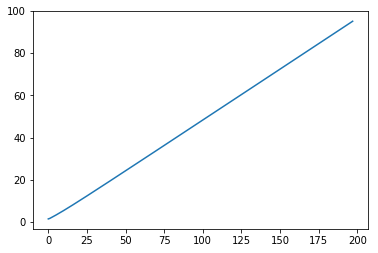

In [12]:
plt.plot(sing_val_log)

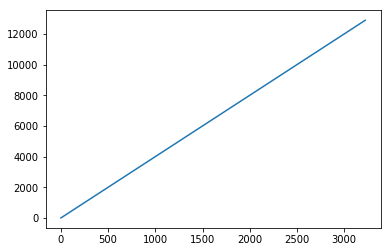

In [12]:
plt.plot(distances_log)